## Imports and Load + Split Data

In [1]:
from __future__ import print_function
import argparse
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from torch.utils.data.sampler import SubsetRandomSampler
import os

train_dataset = datasets.MNIST('../data', train=True, download=True,
            transform=transforms.Compose([      
                transforms.ToTensor(),           
                transforms.Normalize((0.1307,), (0.3081,))
            ]))

test_dataset = datasets.MNIST('../data', train=False,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
            ]))

subset_indices_train = np.load('indices_train.npy')
subset_indices_valid = np.load('indices_valid.npy')

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64,
    sampler=SubsetRandomSampler(subset_indices_train)
)
val_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64,
    sampler=SubsetRandomSampler(subset_indices_valid)
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=64, shuffle=True)

## Best MNIST Classifier

In [8]:
class Net(nn.Module):
    '''
    Build the best MNIST classifier.
    '''
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3,3), stride=1)
        self.conv2 = nn.Conv2d(64, 64, 3, 1)
        self.norm = nn.BatchNorm2d(64)
        self.dropout1 = nn.Dropout2d(0.15)
        self.dropout2 = nn.Dropout2d(0.15)
        self.fc1 = nn.Linear(1600, 64)
        self.fc2 = nn.Linear(64, 10)


    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout2(x)

        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)

        output = F.log_softmax(x, dim=1)
        return output
    
def train(model, train_loader, optimizer, epoch):
    '''
    This is your training function. When you call this function, the model is
    trained for 1 epoch.
    '''
    model.train()   # Set the model to training mode
    losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()               # Clear the gradient
        output = model(data)                # Make predictions
        loss = F.nll_loss(output, target)   # Compute loss
        losses.append(loss.item())
        loss.backward()                     # Gradient computation
        optimizer.step()                    # Perform a single optimization step
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.sampler),
                100. * batch_idx / len(train_loader), loss.item()))     
    return np.average(losses)


def test(model, test_loader):
    model.eval()  
    test_loss = 0
    correct = 0
    test_num = 0
    with torch.no_grad():  
        for data, target in test_loader:
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  
            pred = output.argmax(dim=1, keepdim=True) 
            correct += pred.eq(target.view_as(pred)).sum().item()
            test_num += len(data)

    test_loss /= test_num
    print('\nAccuracy: {}/{} ({:.0f}%)\n'.format( correct, test_num, 100. * correct / test_num))
    return test_loss
    
model = Net()
optimizer = optim.Adadelta(model.parameters(), lr=1.0)
scheduler = StepLR(optimizer, step_size=1, gamma=0.7)

train_loss = []
test_loss = []
epochs = 14
for epoch in range(1, epochs + 1):
    train_loss.append(train(model, train_loader, optimizer, epoch))
    test_loss.append(test(model, val_loader))
    scheduler.step()  

print("Validation Set:")
test(model, val_loader)
print("Training Set:")
test(model, train_loader)

torch.save(model.state_dict(), "best_MNIST_Net.pt")

Train Epoch: 1 [0/51005 (0%)]	Loss: 2.330586
Train Epoch: 1 [640/51005 (1%)]	Loss: 1.294745
Train Epoch: 1 [1280/51005 (3%)]	Loss: 0.452469
Train Epoch: 1 [1920/51005 (4%)]	Loss: 0.742207
Train Epoch: 1 [2560/51005 (5%)]	Loss: 0.694120
Train Epoch: 1 [3200/51005 (6%)]	Loss: 0.418613
Train Epoch: 1 [3840/51005 (8%)]	Loss: 0.303415
Train Epoch: 1 [4480/51005 (9%)]	Loss: 0.259456
Train Epoch: 1 [5120/51005 (10%)]	Loss: 0.334129
Train Epoch: 1 [5760/51005 (11%)]	Loss: 0.269938
Train Epoch: 1 [6400/51005 (13%)]	Loss: 0.280978
Train Epoch: 1 [7040/51005 (14%)]	Loss: 0.210111
Train Epoch: 1 [7680/51005 (15%)]	Loss: 0.252804
Train Epoch: 1 [8320/51005 (16%)]	Loss: 0.147011
Train Epoch: 1 [8960/51005 (18%)]	Loss: 0.211296
Train Epoch: 1 [9600/51005 (19%)]	Loss: 0.318120
Train Epoch: 1 [10240/51005 (20%)]	Loss: 0.158818
Train Epoch: 1 [10880/51005 (21%)]	Loss: 0.033134
Train Epoch: 1 [11520/51005 (23%)]	Loss: 0.147375
Train Epoch: 1 [12160/51005 (24%)]	Loss: 0.091047
Train Epoch: 1 [12800/51005 

Train Epoch: 3 [3200/51005 (6%)]	Loss: 0.019945
Train Epoch: 3 [3840/51005 (8%)]	Loss: 0.024774
Train Epoch: 3 [4480/51005 (9%)]	Loss: 0.041310
Train Epoch: 3 [5120/51005 (10%)]	Loss: 0.001540
Train Epoch: 3 [5760/51005 (11%)]	Loss: 0.028086
Train Epoch: 3 [6400/51005 (13%)]	Loss: 0.007728
Train Epoch: 3 [7040/51005 (14%)]	Loss: 0.001873
Train Epoch: 3 [7680/51005 (15%)]	Loss: 0.010203
Train Epoch: 3 [8320/51005 (16%)]	Loss: 0.003846
Train Epoch: 3 [8960/51005 (18%)]	Loss: 0.004809
Train Epoch: 3 [9600/51005 (19%)]	Loss: 0.005231
Train Epoch: 3 [10240/51005 (20%)]	Loss: 0.001579
Train Epoch: 3 [10880/51005 (21%)]	Loss: 0.026181
Train Epoch: 3 [11520/51005 (23%)]	Loss: 0.009485
Train Epoch: 3 [12160/51005 (24%)]	Loss: 0.001929
Train Epoch: 3 [12800/51005 (25%)]	Loss: 0.001364
Train Epoch: 3 [13440/51005 (26%)]	Loss: 0.015186
Train Epoch: 3 [14080/51005 (28%)]	Loss: 0.003831
Train Epoch: 3 [14720/51005 (29%)]	Loss: 0.058473
Train Epoch: 3 [15360/51005 (30%)]	Loss: 0.048917
Train Epoch: 3

Train Epoch: 5 [5760/51005 (11%)]	Loss: 0.002812
Train Epoch: 5 [6400/51005 (13%)]	Loss: 0.098841
Train Epoch: 5 [7040/51005 (14%)]	Loss: 0.020176
Train Epoch: 5 [7680/51005 (15%)]	Loss: 0.013221
Train Epoch: 5 [8320/51005 (16%)]	Loss: 0.001579
Train Epoch: 5 [8960/51005 (18%)]	Loss: 0.008823
Train Epoch: 5 [9600/51005 (19%)]	Loss: 0.007076
Train Epoch: 5 [10240/51005 (20%)]	Loss: 0.001042
Train Epoch: 5 [10880/51005 (21%)]	Loss: 0.002199
Train Epoch: 5 [11520/51005 (23%)]	Loss: 0.007053
Train Epoch: 5 [12160/51005 (24%)]	Loss: 0.007304
Train Epoch: 5 [12800/51005 (25%)]	Loss: 0.030800
Train Epoch: 5 [13440/51005 (26%)]	Loss: 0.018624
Train Epoch: 5 [14080/51005 (28%)]	Loss: 0.000276
Train Epoch: 5 [14720/51005 (29%)]	Loss: 0.001327
Train Epoch: 5 [15360/51005 (30%)]	Loss: 0.104251
Train Epoch: 5 [16000/51005 (31%)]	Loss: 0.009799
Train Epoch: 5 [16640/51005 (33%)]	Loss: 0.038289
Train Epoch: 5 [17280/51005 (34%)]	Loss: 0.012710
Train Epoch: 5 [17920/51005 (35%)]	Loss: 0.000837
Train E

Train Epoch: 7 [8320/51005 (16%)]	Loss: 0.004587
Train Epoch: 7 [8960/51005 (18%)]	Loss: 0.018730
Train Epoch: 7 [9600/51005 (19%)]	Loss: 0.002856
Train Epoch: 7 [10240/51005 (20%)]	Loss: 0.002675
Train Epoch: 7 [10880/51005 (21%)]	Loss: 0.016139
Train Epoch: 7 [11520/51005 (23%)]	Loss: 0.001192
Train Epoch: 7 [12160/51005 (24%)]	Loss: 0.002959
Train Epoch: 7 [12800/51005 (25%)]	Loss: 0.001642
Train Epoch: 7 [13440/51005 (26%)]	Loss: 0.029638
Train Epoch: 7 [14080/51005 (28%)]	Loss: 0.003587
Train Epoch: 7 [14720/51005 (29%)]	Loss: 0.015179
Train Epoch: 7 [15360/51005 (30%)]	Loss: 0.039251
Train Epoch: 7 [16000/51005 (31%)]	Loss: 0.005882
Train Epoch: 7 [16640/51005 (33%)]	Loss: 0.001186
Train Epoch: 7 [17280/51005 (34%)]	Loss: 0.001706
Train Epoch: 7 [17920/51005 (35%)]	Loss: 0.013681
Train Epoch: 7 [18560/51005 (36%)]	Loss: 0.068855
Train Epoch: 7 [19200/51005 (38%)]	Loss: 0.021615
Train Epoch: 7 [19840/51005 (39%)]	Loss: 0.004599
Train Epoch: 7 [20480/51005 (40%)]	Loss: 0.024728
Tra

Train Epoch: 9 [10880/51005 (21%)]	Loss: 0.008719
Train Epoch: 9 [11520/51005 (23%)]	Loss: 0.000101
Train Epoch: 9 [12160/51005 (24%)]	Loss: 0.005234
Train Epoch: 9 [12800/51005 (25%)]	Loss: 0.001354
Train Epoch: 9 [13440/51005 (26%)]	Loss: 0.061550
Train Epoch: 9 [14080/51005 (28%)]	Loss: 0.018965
Train Epoch: 9 [14720/51005 (29%)]	Loss: 0.001564
Train Epoch: 9 [15360/51005 (30%)]	Loss: 0.000415
Train Epoch: 9 [16000/51005 (31%)]	Loss: 0.043009
Train Epoch: 9 [16640/51005 (33%)]	Loss: 0.010522
Train Epoch: 9 [17280/51005 (34%)]	Loss: 0.014553
Train Epoch: 9 [17920/51005 (35%)]	Loss: 0.004091
Train Epoch: 9 [18560/51005 (36%)]	Loss: 0.000303
Train Epoch: 9 [19200/51005 (38%)]	Loss: 0.003219
Train Epoch: 9 [19840/51005 (39%)]	Loss: 0.051543
Train Epoch: 9 [20480/51005 (40%)]	Loss: 0.021633
Train Epoch: 9 [21120/51005 (41%)]	Loss: 0.004181
Train Epoch: 9 [21760/51005 (43%)]	Loss: 0.005587
Train Epoch: 9 [22400/51005 (44%)]	Loss: 0.005459
Train Epoch: 9 [23040/51005 (45%)]	Loss: 0.043202


Train Epoch: 11 [12160/51005 (24%)]	Loss: 0.002426
Train Epoch: 11 [12800/51005 (25%)]	Loss: 0.006307
Train Epoch: 11 [13440/51005 (26%)]	Loss: 0.000794
Train Epoch: 11 [14080/51005 (28%)]	Loss: 0.003851
Train Epoch: 11 [14720/51005 (29%)]	Loss: 0.005577
Train Epoch: 11 [15360/51005 (30%)]	Loss: 0.014773
Train Epoch: 11 [16000/51005 (31%)]	Loss: 0.043171
Train Epoch: 11 [16640/51005 (33%)]	Loss: 0.000737
Train Epoch: 11 [17280/51005 (34%)]	Loss: 0.000921
Train Epoch: 11 [17920/51005 (35%)]	Loss: 0.004339
Train Epoch: 11 [18560/51005 (36%)]	Loss: 0.002797
Train Epoch: 11 [19200/51005 (38%)]	Loss: 0.017565
Train Epoch: 11 [19840/51005 (39%)]	Loss: 0.001167
Train Epoch: 11 [20480/51005 (40%)]	Loss: 0.029530
Train Epoch: 11 [21120/51005 (41%)]	Loss: 0.000063
Train Epoch: 11 [21760/51005 (43%)]	Loss: 0.005302
Train Epoch: 11 [22400/51005 (44%)]	Loss: 0.018376
Train Epoch: 11 [23040/51005 (45%)]	Loss: 0.002963
Train Epoch: 11 [23680/51005 (46%)]	Loss: 0.002674
Train Epoch: 11 [24320/51005 (4

Train Epoch: 13 [12800/51005 (25%)]	Loss: 0.002839
Train Epoch: 13 [13440/51005 (26%)]	Loss: 0.001090
Train Epoch: 13 [14080/51005 (28%)]	Loss: 0.014325
Train Epoch: 13 [14720/51005 (29%)]	Loss: 0.001048
Train Epoch: 13 [15360/51005 (30%)]	Loss: 0.000442
Train Epoch: 13 [16000/51005 (31%)]	Loss: 0.000703
Train Epoch: 13 [16640/51005 (33%)]	Loss: 0.004146
Train Epoch: 13 [17280/51005 (34%)]	Loss: 0.003064
Train Epoch: 13 [17920/51005 (35%)]	Loss: 0.026992
Train Epoch: 13 [18560/51005 (36%)]	Loss: 0.000773
Train Epoch: 13 [19200/51005 (38%)]	Loss: 0.090250
Train Epoch: 13 [19840/51005 (39%)]	Loss: 0.003449
Train Epoch: 13 [20480/51005 (40%)]	Loss: 0.000129
Train Epoch: 13 [21120/51005 (41%)]	Loss: 0.008820
Train Epoch: 13 [21760/51005 (43%)]	Loss: 0.000138
Train Epoch: 13 [22400/51005 (44%)]	Loss: 0.006140
Train Epoch: 13 [23040/51005 (45%)]	Loss: 0.002567
Train Epoch: 13 [23680/51005 (46%)]	Loss: 0.000622
Train Epoch: 13 [24320/51005 (48%)]	Loss: 0.001230
Train Epoch: 13 [24960/51005 (4

## Training and Test Loss as a Function of Epoch

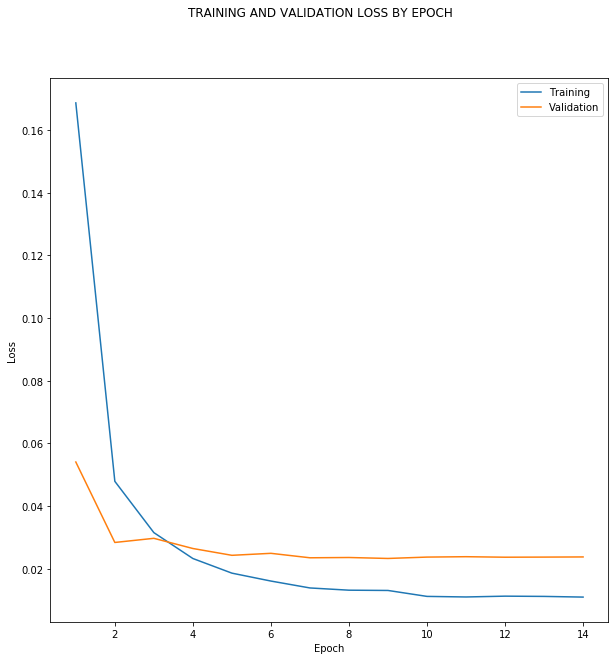

In [18]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(figsize=(10, 10))
plt.plot(range(1, epochs+1), train_loss, label="Training")
plt.plot(range(1, epochs+1), test_loss, label="Validation")
plt.xlabel("Epoch")
plt.ylabel("Loss")
fig.suptitle("TRAINING AND VALIDATION LOSS BY EPOCH")
plt.legend()
plt.savefig("train_and_valid_loss_by_epoch.png")